---
title: "parametric generative classification"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## question

We are given a list of heights for men and women. Given one more data point (180 cm), could we assign a probability that it belongs to either class?

In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from scipy.stats import norm

In [2]:
#| code-summary: "generate data"
df_boys = pd.read_csv('../archive/data/height/boys_height_stats.csv', index_col=0)
df_girls = pd.read_csv('../archive/data/height/girls_height_stats.csv', index_col=0)
age = 20.0
mu_boys = df_boys.loc[age, 'mu']
mu_girls = df_girls.loc[age, 'mu']
sigma_boys = df_boys.loc[age, 'sigma']
sigma_girls = df_girls.loc[age, 'sigma']

N_boys = 150
N_girls = 200
np.random.seed(314)  # set scipy seed for reproducibility
sample_boys = norm.rvs(size=N_boys, loc=mu_boys, scale=sigma_boys)
sample_girls = norm.rvs(size=N_girls, loc=mu_girls, scale=sigma_girls)
# pandas dataframe with the two samples in it
df = pd.DataFrame({
    'height (cm)': np.concatenate([sample_boys, sample_girls]),
    'sex': ['M'] * N_boys + ['F'] * N_girls
})
df = df.sample(frac=1, random_state=314).reset_index(drop=True)
df

,height (cm),sex
0,178.558416,M
1,173.334306,M
2,183.084154,M
3,178.236047,F
4,175.868642,M
...,...,...
345,177.387837,M
346,157.122325,F
347,166.891746,F
348,181.090312,M


## explaining "parametric generative classification"

* **Parametric**: we assume a specific distribution for the data. In this case, we'll assume a Gaussian distribution. We call this parametric because the distribution can be fully described by a finite set of **parameters** (mean and variance for Gaussian).
* **Generative**: we model the distribution of each class separately. This would allow us to **generate** new data points from the learned distributions. "Learned" means estimating the parameters of the distributions from the sample data.
* **Classification**: we classify a new data point by comparing the likelihoods of it belonging to each class, given the learned distributions.

## visualizing the problem

In [3]:
are_male = df['sex']=='M'
boys_sample = df[are_male]['height (cm)'].to_numpy()
girls_sample = df[~are_male]['height (cm)'].to_numpy()

xbar_boys = boys_sample.mean()
xbar_girls = girls_sample.mean()
s_boys = boys_sample.std(ddof=1)
s_girls = girls_sample.std(ddof=1)

men:   mean=177.4 cm, std=6.7 cm
women: mean=163.5 cm, std=7.3 cm


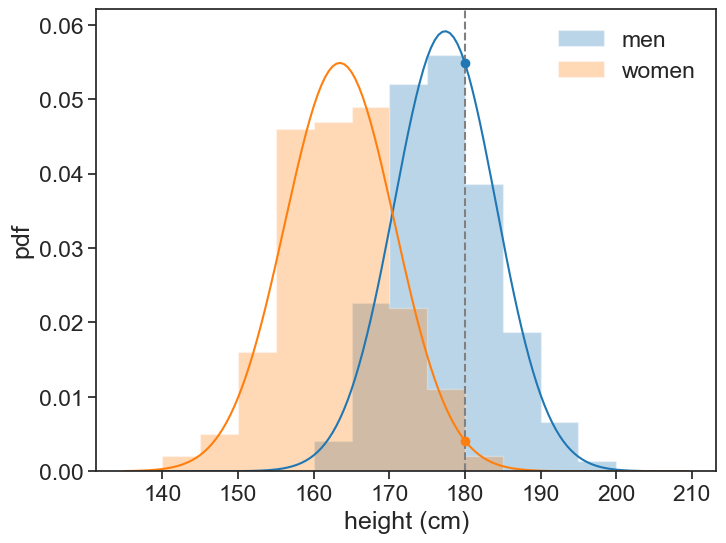

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot histogram
bins = np.arange(135, 210, 5)
ax.hist(boys_sample, bins=bins, alpha=0.3, density=True, label='men', color='tab:blue', histtype='stepfilled')
ax.hist(girls_sample, bins=bins, alpha=0.3, density=True, label='women', color='tab:orange', histtype='stepfilled')
# plot gaussian pdf based on sample mean and std
x = np.arange(135, 210, 0.5)
pdf_boys = norm.pdf(x, loc=xbar_boys, scale=s_boys)
pdf_girls = norm.pdf(x, loc=xbar_girls, scale=s_girls)
ax.plot(x, pdf_boys, color='tab:blue')
ax.plot(x, pdf_girls, color='tab:orange')
h0 = 180
# plot vertical line at h0
ax.axvline(h0, color='gray', linestyle='--')
# plot circles where each pdf intersects h0
likelihood_boys = norm.pdf(h0, loc=xbar_boys, scale=s_boys)
likelihood_girls = norm.pdf(h0, loc=xbar_girls, scale=s_girls)
ax.plot(h0, likelihood_boys, marker='o', color='tab:blue')
ax.plot(h0, likelihood_girls, marker='o', color='tab:orange')

print(f"men:   mean={xbar_boys:.1f} cm, std={s_boys:.1f} cm")
print(f"women: mean={xbar_girls:.1f} cm, std={s_girls:.1f} cm")

ax.legend(frameon=False)
ax.set_xlabel('height (cm)')
ax.set_ylabel('pdf');

From the sample data, we can compute the mean and standard deviation for each sex (the generative part). We printed these values above. We can then use these parameters to compute the likelihood of the new data point (180 cm) belonging to each class using the Gaussian probability density function (the parametric part). These are plotted as circles in the graph.

## Bayes' theorem

We can then use Bayes' theorem to compute the posterior probabilities of the new data point belonging to each class (the classification part). Bayes' theorem states that:

$$
P(\text{man} | x) = \frac{P(x | \text{man})}{P(x)} P(\text{man})
$$

* **posterior**, $P(\text{man} | x)$. This is what we are looking for, the probability of a new data point corresponding to a man, given that its height is $x$.
* **likelihood**, $P(x | \text{man})$. This is the likelihood of observing a height $x$ given that we know it is a man.
* **evidence**, $P(x)$. This is the total probability of observing a height $x$ across all classes (regardless of sex). It acts as a normalization factor. We calculate the evidence using the law of total probability:
  \begin{align*}
  P(x) &= P(x \cap \text{man}) + P(x \cap \text{woman}) \\
       &=P(x|\text{man})\cdot P(\text{man}) + P(x|\text{woman})\cdot P(\text{woman})
  \end{align*}
* **prior**, $P(\text{man})$. This is the overall probability of a person being a man in my dataset (regardless of their height).


Think of this as a "battle of likelihoods," adjusted for the group sizes. You have two groups, men and women, and you've modeled their typical heights. When you get a new height, $x$, you ask two main questions:

1.  **Likelihood Question:** How "typical" is height $x$ for a man compared to how typical it is for a woman? If men in your data are generally tall and $x$ is a tall height, it's more likely to be a man. We measure this "typicalness" using a probability distribution.
2.  **Prior Belief Question:** In your dataset, are men or women more common? If your dataset contains 90 women and 10 men, any new person is, initially, more likely to be a woman, regardless of their height.


## Step-by-Step Calculation

**Step 1: Model Your Data**

We assume a Gaussian distribution, and calculate the sample mean and standard deviation for each sex.

In [5]:
#| output: true
#| echo: false
print(f"men:   mean={xbar_boys:.1f} cm, std={s_boys:.1f} cm")
print(f"women: mean={xbar_girls:.1f} cm, std={s_girls:.1f} cm")

men:   mean=177.4 cm, std=6.7 cm
women: mean=163.5 cm, std=7.3 cm


**Step 2: Calculate the Priors**

The priors are simply the proportion of each group in the total dataset.

$$P(\text{Man}) = \frac{N_\text{men}}{N_\text{men} + N_\text{women}}$$

$$P(\text{Woman}) = \frac{N_\text{women}}{N_\text{men} + N_\text{women}}$$

**Step 3: Calculate the Likelihoods**

Using the normal distribution's probability density function (PDF), find the likelihood of the new height $h$ for each model. The PDF formula is:

$$f(x | \bar{x}, s) = \frac{1}{s\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-\bar{x}}{s}\right)^2}$$

1.  **Likelihood for Men:** Plug $x$ into the PDF for the men's model.  
    $P(x | \text{Man}) = f(x | \bar{x}_\text{men}, s_\text{men})$

2.  **Likelihood for Women:** Plug $x$ into the PDF for the women's model.  
    $P(x | \text{Woman}) = f(x | \bar{x}_\text{women}, s_\text{women})$

**Step 4: Put It All Together**

Now, apply Bayes' Theorem. The "evidence" term $P(x)$ in the denominator is the sum of all ways you could observe height $x$:

$$
P(x) = P(x | \text{Man}) \cdot P(\text{Man}) + P(x | \text{Woman}) \cdot P(\text{Woman})
$$

So, the final calculation for the probability of being a man is:

$$
P(\text{Man} | x) = \frac{P(x | \text{Man}) \cdot P(\text{Man})}{P(x | \text{Man}) \cdot P(\text{Man}) + P(x | \text{Woman}) \cdot P(\text{Woman})}
$$.

Crunching the number gives:

In [6]:
h0 = 180.0
likelihood_boys = norm.pdf(h0, loc=xbar_boys, scale=s_boys)
likelihood_girls = norm.pdf(h0, loc=xbar_girls, scale=s_girls)
prior_boys = N_boys / (N_boys + N_girls)
prior_girls = N_girls / (N_boys + N_girls)
evidence = likelihood_boys * prior_boys + likelihood_girls * prior_girls
p_man_given_180 = likelihood_boys * prior_boys / evidence
print(f"Answer: {p_man_given_180 * 100:.2f}%.")

Answer: 90.92%.


<div class="alert alert-primary">
The probability that the person is a man, given that their height is 180 cm, is 90.92%
</div>